In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sb
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu

import matplotlib.patches as mpatches
from scipy.stats import wilcoxon, ttest_ind
from scipy.stats import pearsonr

from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.expand_frame_repr', True)
import warnings
warnings.filterwarnings('ignore')

path = '/home/ripper8/projects/working_data/GRNv3knockouts/analysis'
experiments = ['reg10m2', 'reg2m2']

In [ ]:
traits = ['disp_y', 'distance', 'extremities_prop', 'symmetry']

df_traits = {}
df_categ_traits = {}

for trait in traits:
    print('>>>>>',trait)
    df_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effects_{trait}.csv')
    df_traits[trait]['epistasis_percent'] = df_traits[trait]['positive'] + df_traits[trait]['negative']
    df_traits[trait]['avg_negative']  = df_traits[trait]['avg_negative'] * -1

    df_categ_traits[trait] = pd.read_csv(f'{path}/knockouts/data/effectscateg_{trait}.csv')

   

>>>>> disp_y
>> reg10m2

Metric: epistasis_percent, p-value: 0.4527
0.14596161535385838

Metric: avg_positive, p-value: 0.0
3.8865215427620567

Metric: avg_negative, p-value: 0.0
2.211920221117092


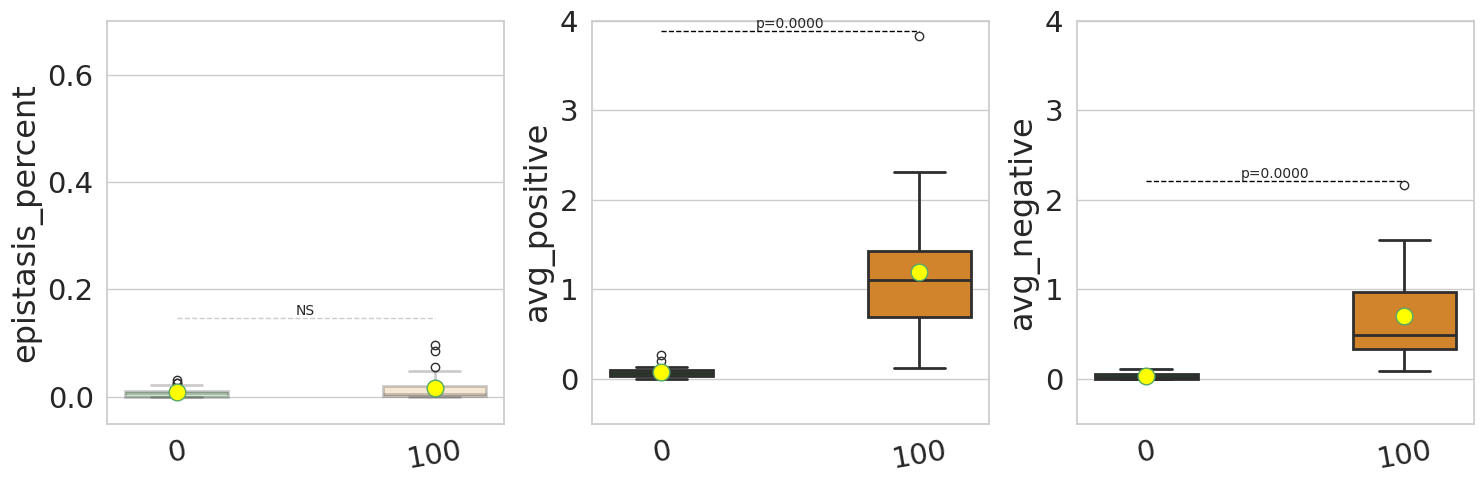

>> reg2m2

Metric: epistasis_percent, p-value: 0.0001
0.7026315789473684

Metric: avg_positive, p-value: 0.0
2.1321930736392676

Metric: avg_negative, p-value: 0.0
3.605439821007894


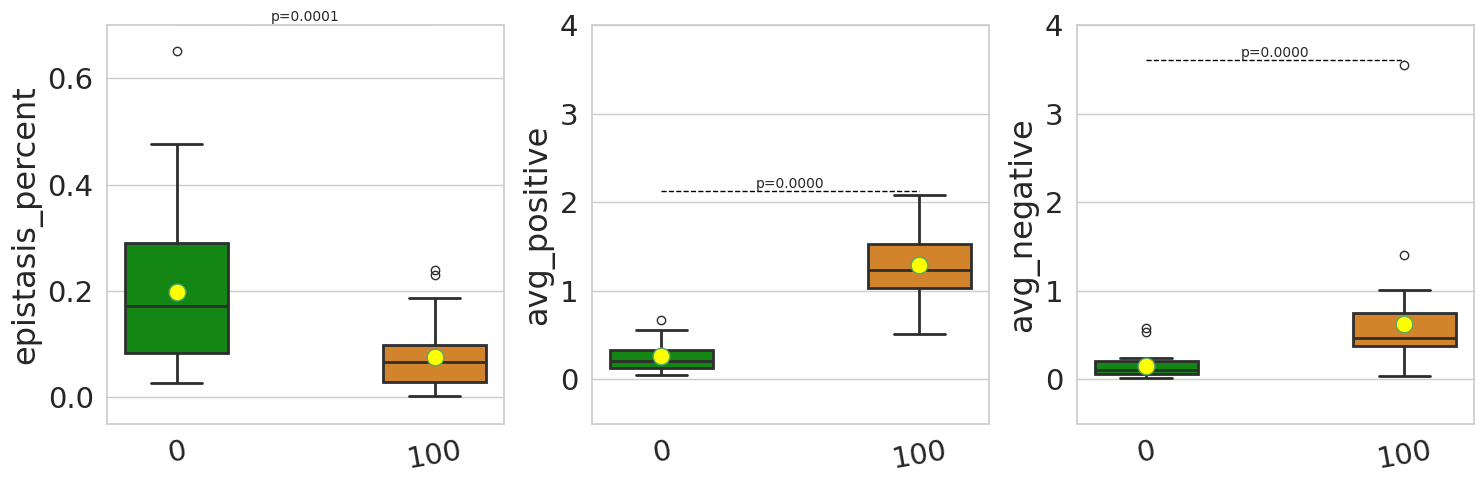

>>>>> distance
>> reg10m2

Metric: epistasis_percent, p-value: 0.2945
0.1448801742919389

Metric: avg_positive, p-value: 0.395
18.05

Metric: avg_negative, p-value: 0.0716
19.05


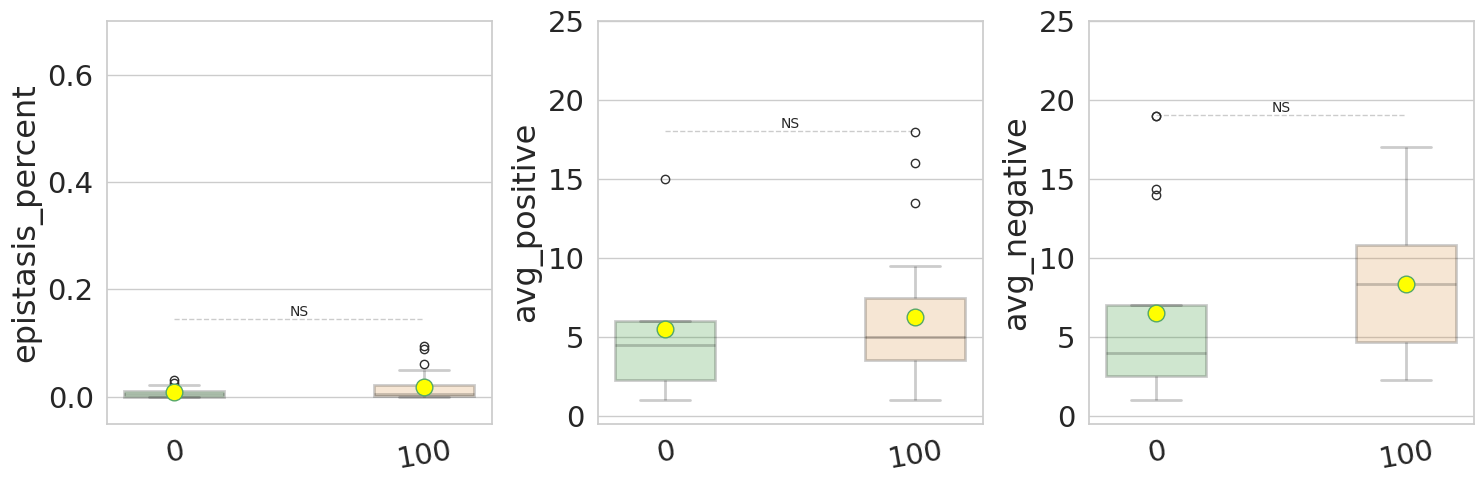

>> reg2m2

Metric: epistasis_percent, p-value: 0.0001
0.6868421052631579

Metric: avg_positive, p-value: 0.0687
20.05

Metric: avg_negative, p-value: 0.0234
26.56063829787234


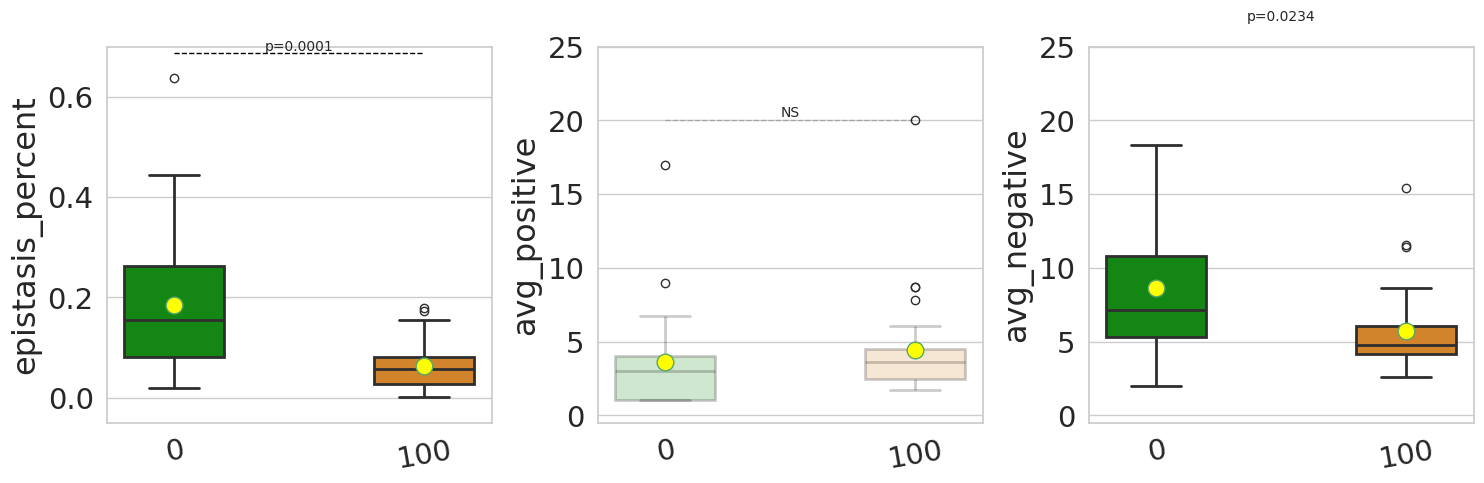

>>>>> extremities_prop
>> reg10m2

Metric: epistasis_percent, p-value: 0.3819
0.1055777688924429

Metric: avg_positive, p-value: 0.0001
1.05

Metric: avg_negative, p-value: 0.0073
1.05


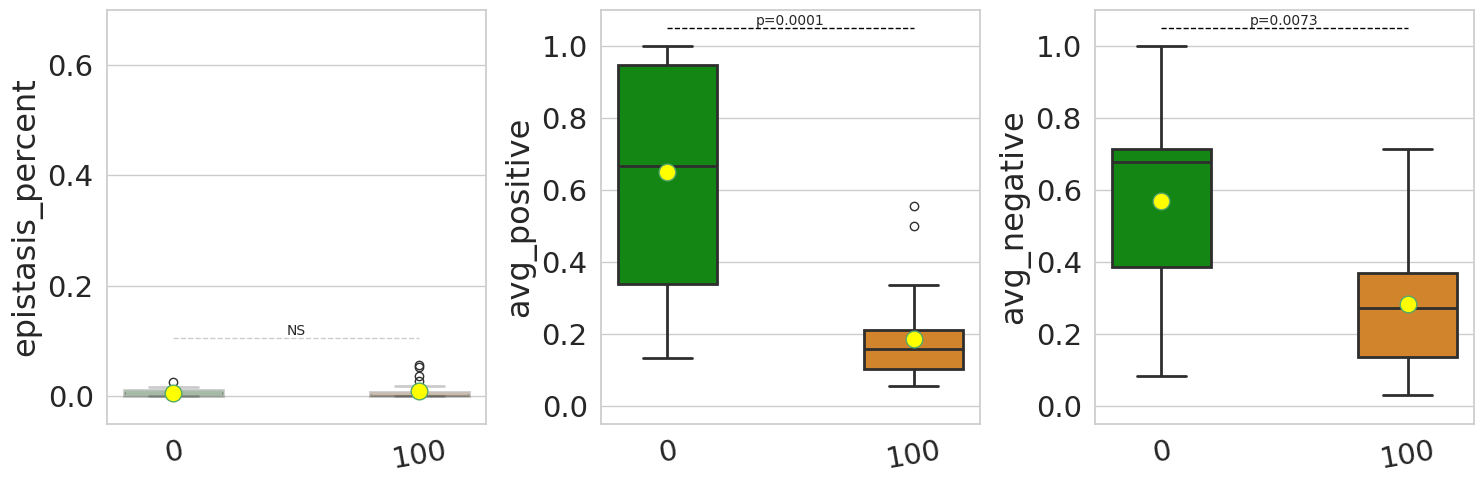

>> reg2m2

Metric: epistasis_percent, p-value: 0.0
0.6078947368421052

Metric: avg_positive, p-value: 0.0009
0.46269841269841266

Metric: avg_negative, p-value: 0.0036
0.675


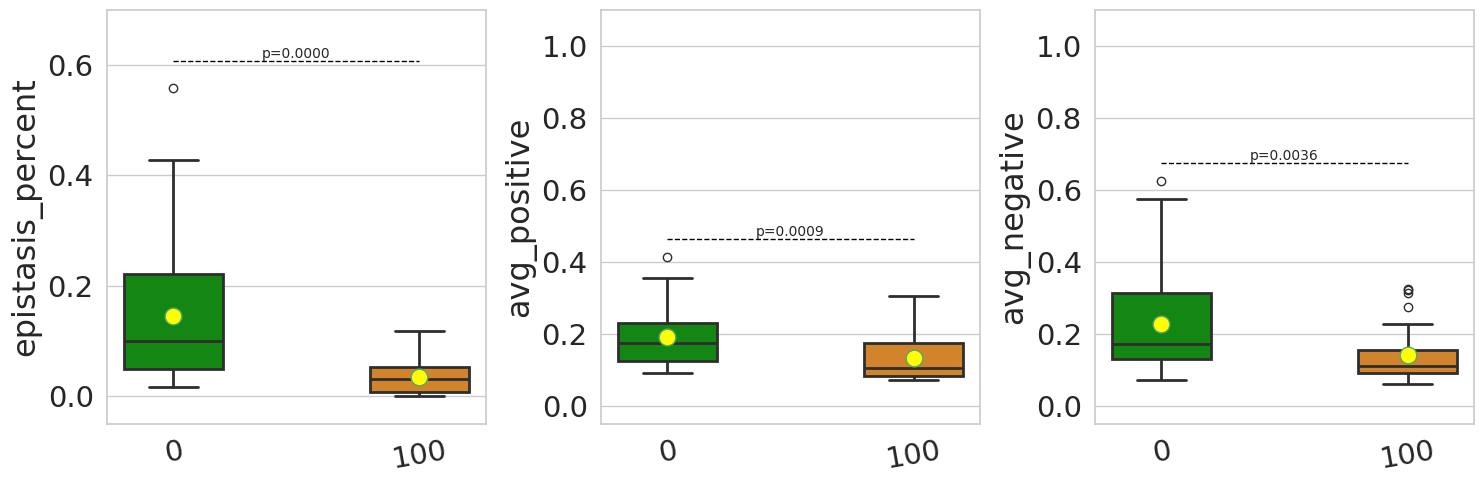

>>>>> symmetry
>> reg10m2

Metric: epistasis_percent, p-value: 0.3661
0.13071895424836588

Metric: avg_positive, p-value: 0.0002
1.2642857142857145

Metric: avg_negative, p-value: 0.0335
1.05


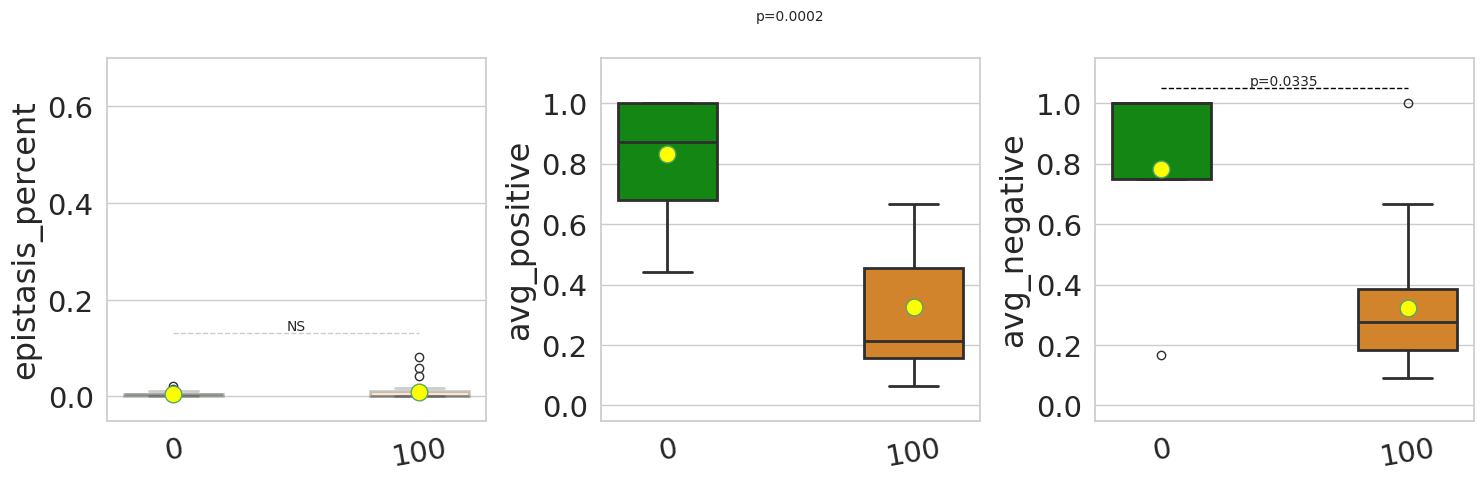

>> reg2m2

Metric: epistasis_percent, p-value: 0.0001
0.6026315789473683

Metric: avg_positive, p-value: 0.0001
1.05

Metric: avg_negative, p-value: 0.0116
0.8833333333333334


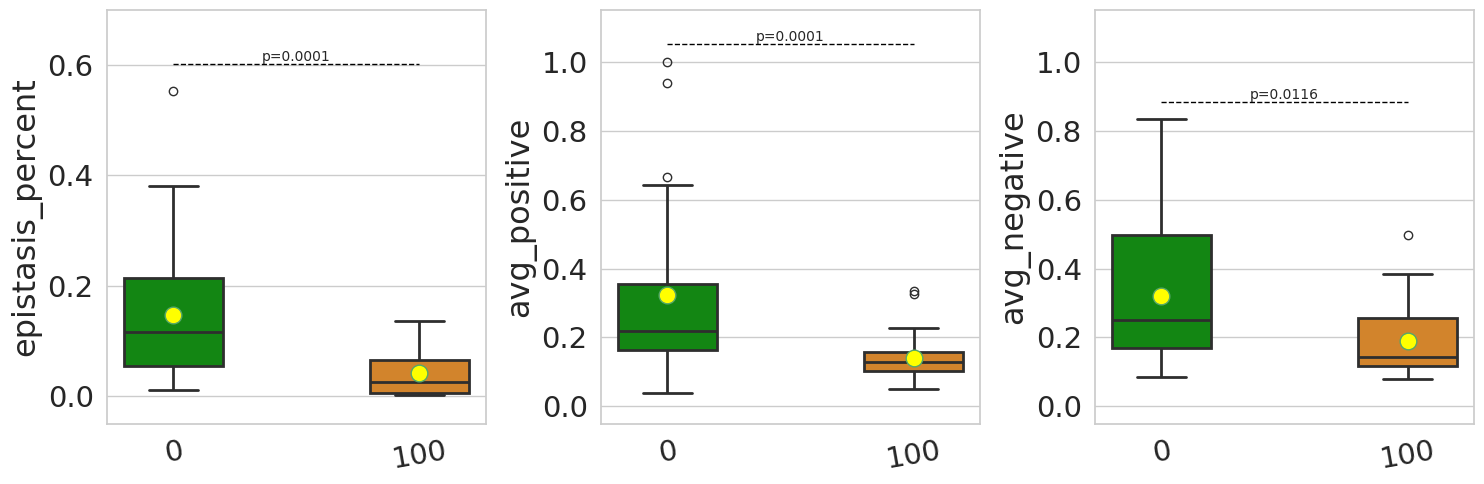

In [384]:


### EPISTASIS CHANGES ###

metrics = ['epistasis_percent',  'avg_positive',  'avg_negative']

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_traits[trait].copy(deep=True)
    

    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
           # print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)

            y_max = filtered_clean[f'{metric}'].max() + 0.05  #
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
            
            if metric in ['epistasis_percent']:
                ax.set_ylim(-0.05, 0.7)

            if metric == 'avg_positive' or metric == 'avg_negative':
                if trait in avg_pos_scale.keys():
                    ax.set_ylim(avg_pos_scale[trait][0], avg_pos_scale[trait][1])
      
            ax.tick_params(axis='x', labelrotation=10)
            
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')
       
        plt.tight_layout()
        plt.show()







>>>>> disp_y
>> reg10m2


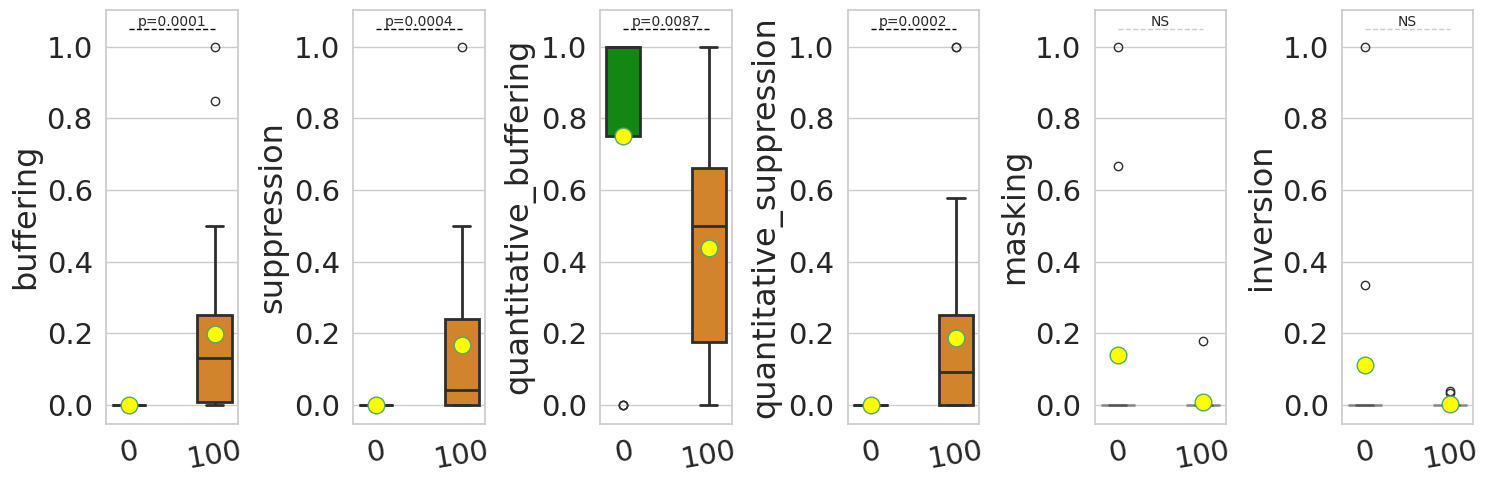

>> reg2m2


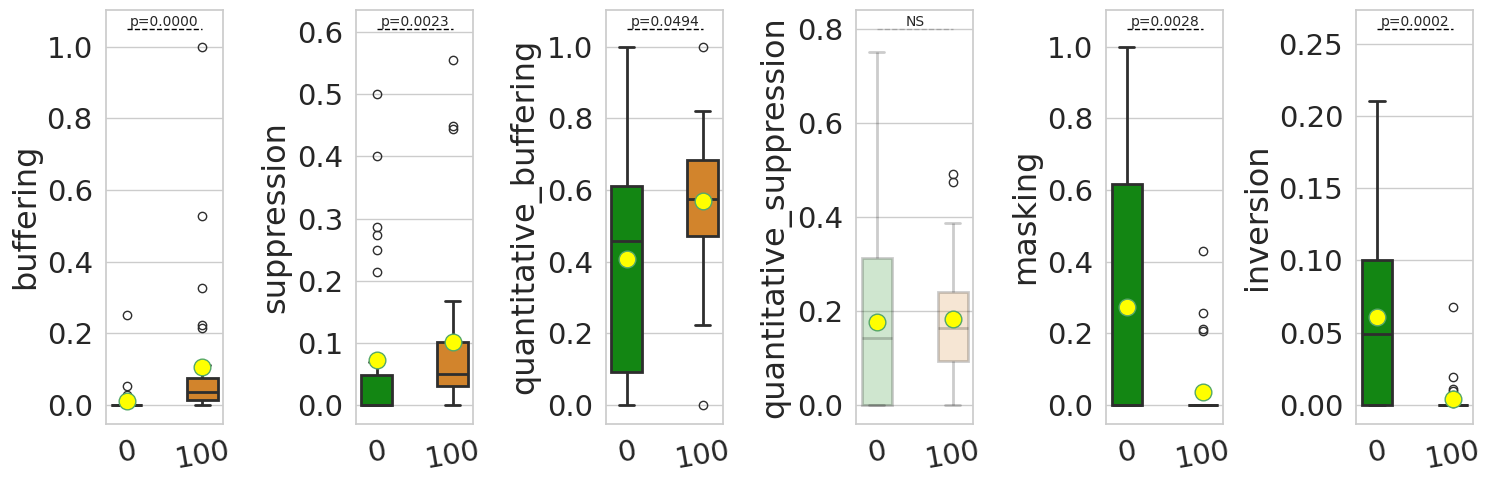

>>>>> distance
>> reg10m2


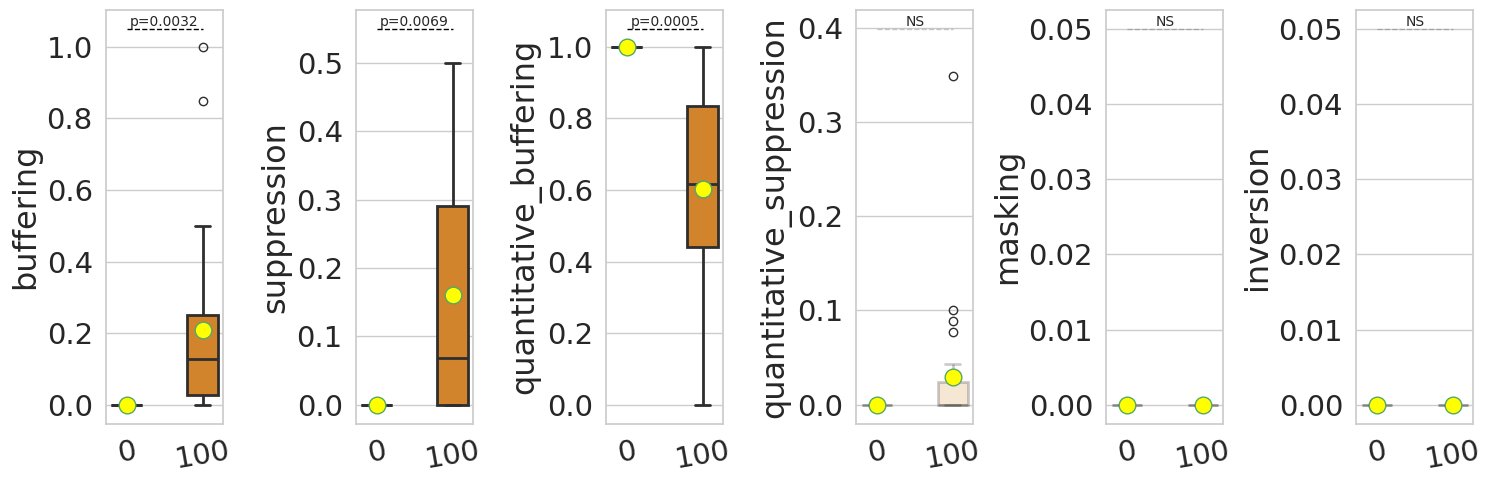

>> reg2m2


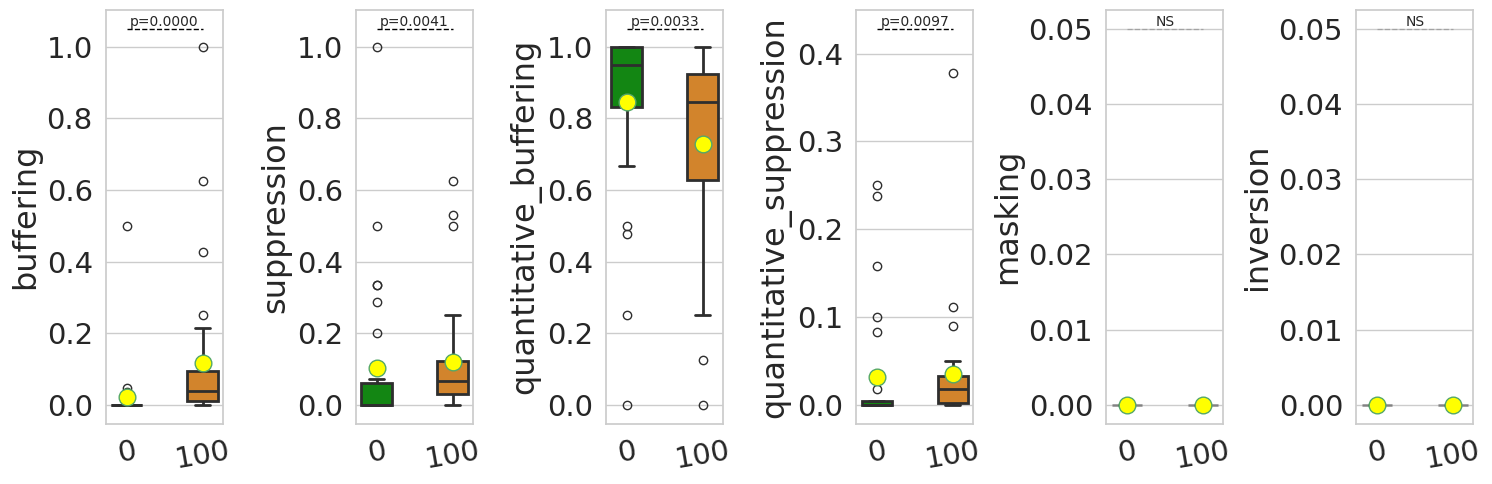

>>>>> extremities_prop
>> reg10m2


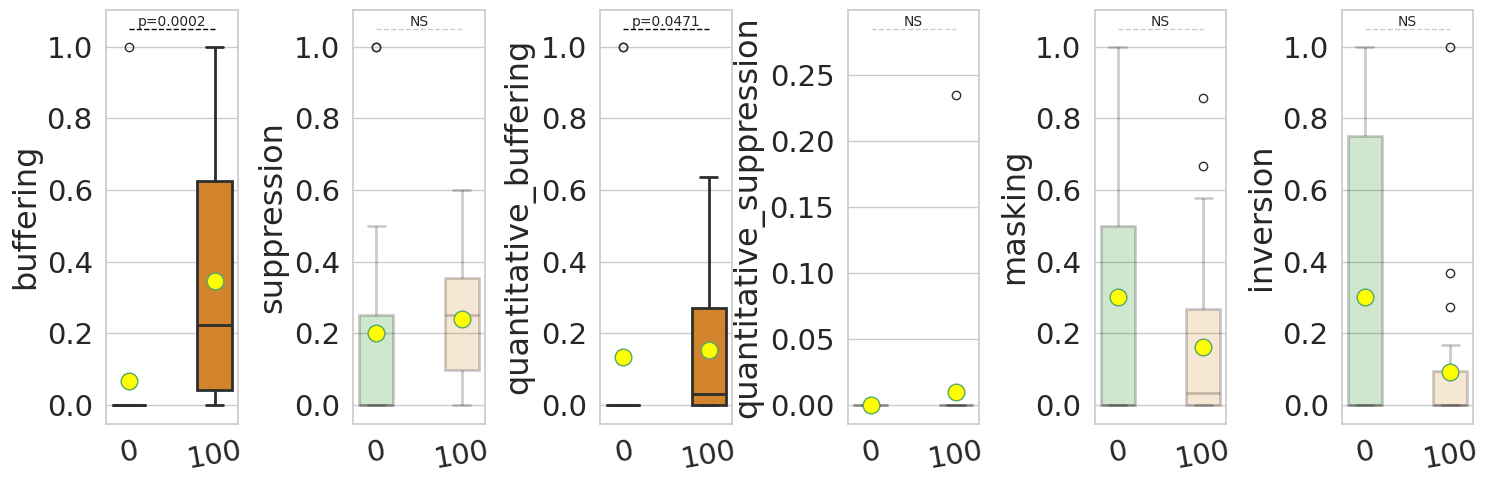

>> reg2m2


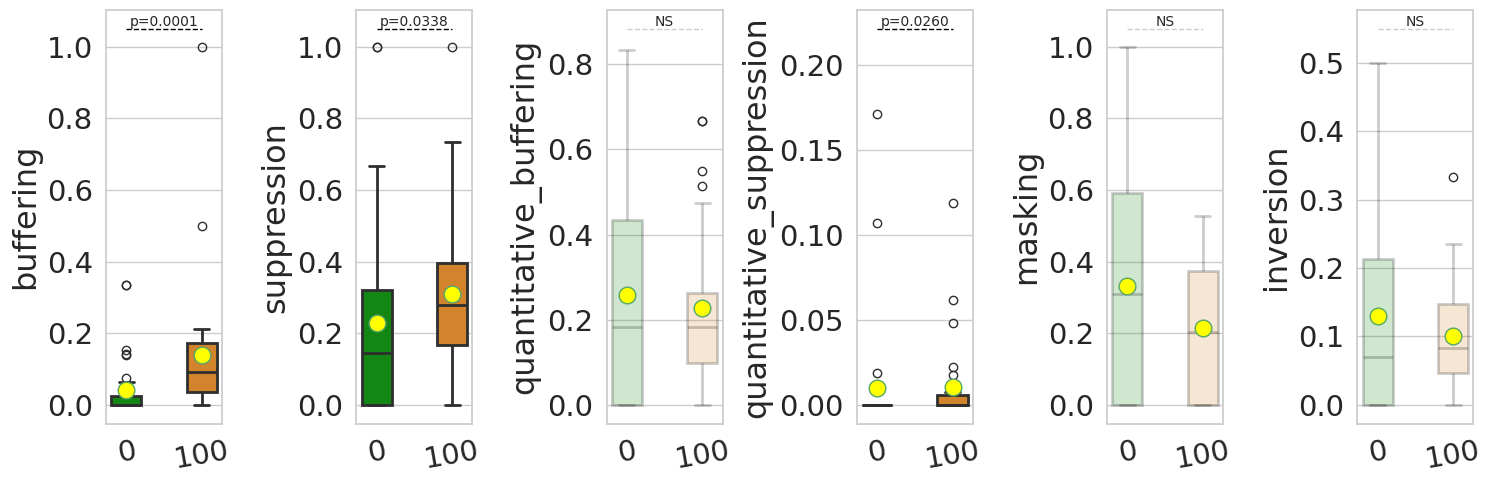

>>>>> symmetry
>> reg10m2


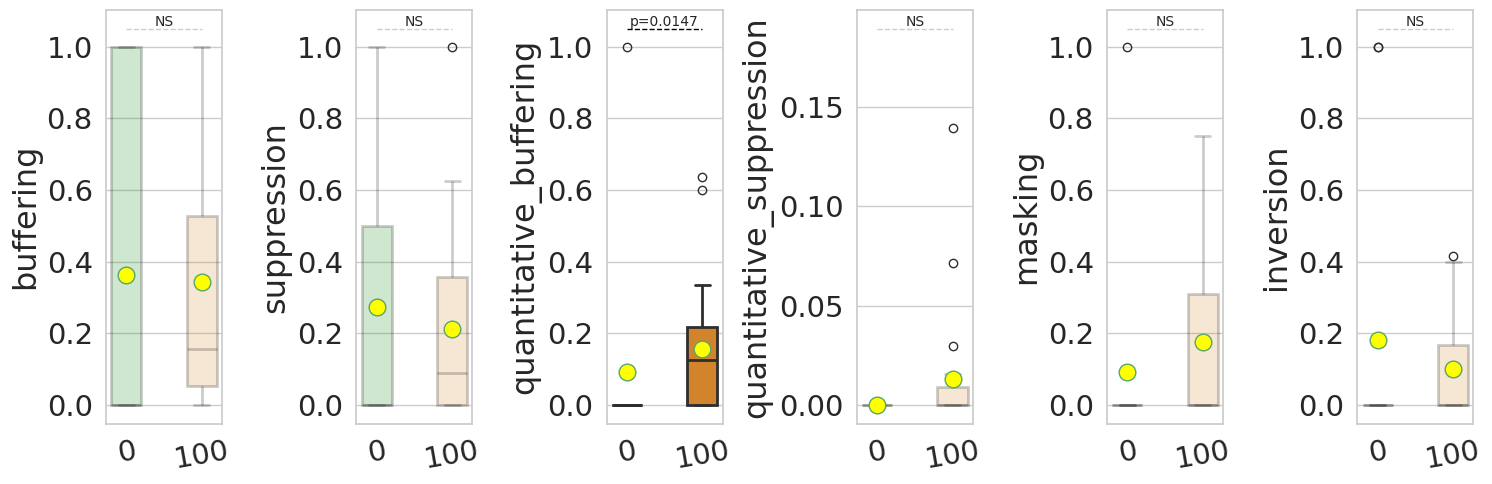

>> reg2m2


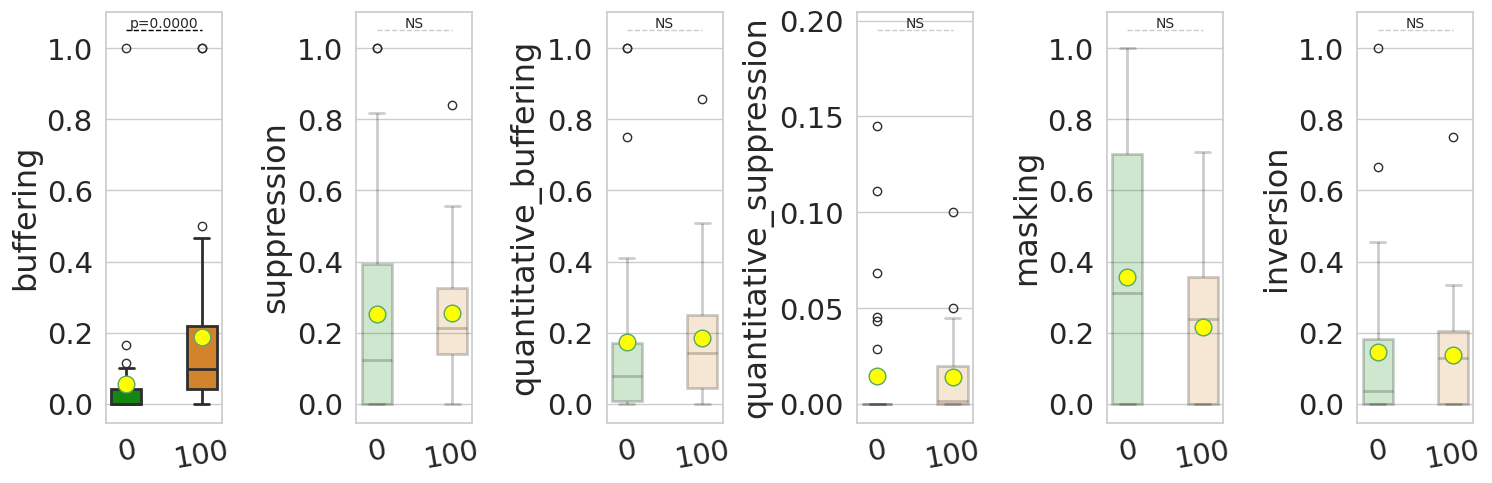

In [382]:
### EPISTASIS CATEG CHANGES ###
 
metrics = ['buffering', 'suppression', 'quantitative_buffering', 'quantitative_suppression', 'masking', 'inversion']

clrs = ['#009900',
        '#EE8610']

avg_pos_scale = {'disp_y': [-0.5, 4],'extremities_prop': [-0.05, 1.1],'symmetry': [-0.05, 1.15], 'distance': [-0.5, 25]}

for trait in traits:
    print('>>>>>',trait)
    df_trait = df_categ_traits[trait].copy(deep=True)
    
    for exp in experiments:
        print('>>',exp)
        df_trait_exp = df_trait[df_trait['experiment_name'] == exp]
        df_trait_exp = df_trait_exp[ (df_trait_exp['ranking'] == 'best') ] 
        df_trait_exp = df_trait_exp[ (df_trait_exp['epistasis'] > 0) ] 
      
        df_trait_exp[metrics] = df_trait_exp[metrics].fillna(0)
        
        fig, axes = plt.subplots(1, 6, figsize=(15, 5))  
        sb.set(rc={"axes.titlesize": 23, "axes.labelsize": 23, 'ytick.labelsize': 21, 'xtick.labelsize': 21})
        sb.set_style("whitegrid")
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            filtered_clean = df_trait_exp[pd.notna(df_trait_exp[metric])]
            ini_gen = filtered_clean[filtered_clean['gen'] == 0][f'{metric}']
            end_gen = filtered_clean[filtered_clean['gen'] == 100][f'{metric}']

            _, p_value = mannwhitneyu(ini_gen, end_gen, alternative='two-sided')
            #print(f"\nMetric: {metric}, p-value: {round(p_value, 4)}")

            sb.boxplot(x='gen', y=f'{metric}', data=filtered_clean,
                       palette=clrs, width=0.4, showmeans=True, linewidth=2, fliersize=6,
                       meanprops={"marker": "o", "markerfacecolor": "yellow", "markersize": "12"}, ax=ax)
    
            y_max = filtered_clean[f'{metric}'].max() + 0.05             
            x_positions = [0, 1]  
            ax.plot(x_positions, [y_max, y_max], color='black', linestyle='--', linewidth=1)
            if p_value >= 0.05:
                sig = 'NS'
                alpha = 0.2
                for patch in ax.patches:
                    patch.set_alpha(alpha)
                    patch.set_edgecolor((0.0, 0.0, 0.0, alpha))  # Example RGBA border color
                for line in ax.lines:
                    if line.get_linestyle() == '-' or line.get_linestyle() == '--':
                        line.set_color((0.0, 0.0, 0.0, alpha))  
                 
            else:
                sig = f'p={p_value:.4f}'
            ax.text(x=0.5, y=y_max, s=sig, ha='center', va='bottom', fontsize=10)
      
            ax.tick_params(axis='x', labelrotation=10)
            ax.set_xlabel('')
            ax.set_ylabel(f'{metric}')

        plt.tight_layout()
        plt.show()




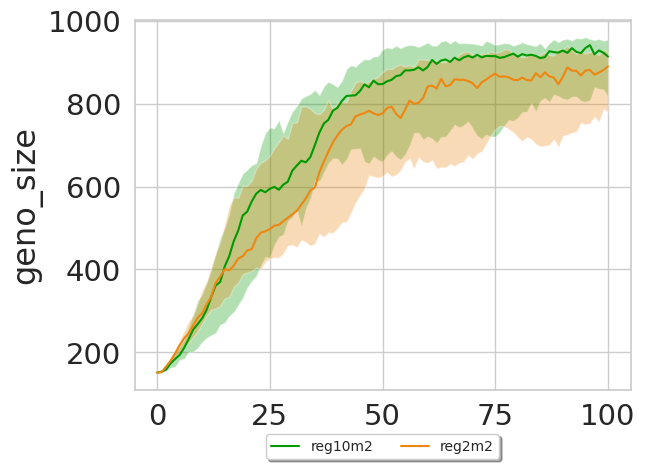

<Figure size 640x480 with 0 Axes>

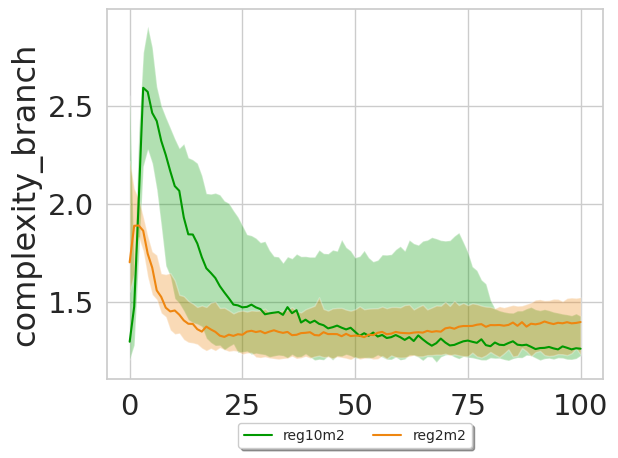

<Figure size 640x480 with 0 Axes>

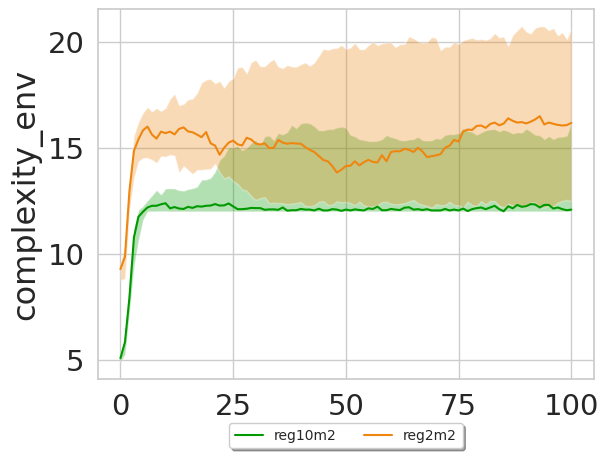

reg10m2 corr dispy and genosize
Pearson Correlation Coefficient: 0.5237111816705469
P-value: 0.0
reg2m2 corr dispy and genosize
Pearson Correlation Coefficient: 0.46004437923771413
P-value: 0.0


<Figure size 640x480 with 0 Axes>

In [316]:

### COMPLEXITY AND GENO SIZE PROGRESSION


df_complexity = pd.read_csv(f'{path}/complexity/complexity.csv')

grouped = df_complexity.groupby(['experiment_name', 'run', 'gen'])
df_complexity_inner = grouped.agg({
    'geno_size': 'mean',
    'complexity_branch': 'mean',
    'complexity_env': 'mean'
})
df_complexity_inner = df_complexity_inner.reset_index()

q1 = lambda x: x.quantile(0.25)
q3 = lambda x: x.quantile(0.75)

grouped = df_complexity_inner.groupby(['experiment_name', 'gen'])
df_complexity_outer = grouped.agg({
    'geno_size': ['median', q1, q3],
    'complexity_branch': ['median', q1, q3],
    'complexity_env': ['median', q1, q3]
})
df_complexity_outer.columns = [
    ('geno_size', 'median'), ('geno_size', 'Q1'), ('geno_size', 'Q3'),
    ('complexity_branch', 'median'), ('complexity_branch', 'Q1'), ('complexity_branch', 'Q3'),
    ('complexity_env', 'median'), ('complexity_env', 'Q1'), ('complexity_env', 'Q3')
]
df_complexity_outer.columns = ['_'.join(col) for col in df_complexity_outer.columns]
df_complexity_outer = df_complexity_outer.reset_index()

metrics = ['geno_size', 'complexity_branch', 'complexity_env']
for metric in metrics:

    font = {'font.size': 20}
    plt.rcParams.update(font)
    fig, ax = plt.subplots()

    plt.xlabel('')
    plt.ylabel(f'{metric}')

    for idx_experiment, exp in enumerate(experiments):
        metric_exp = df_complexity_outer[df_complexity_outer['experiment_name'] == exp]
       # display(metric_exp)

        ax.plot(metric_exp['gen'], metric_exp[f'{metric}_median'],
                    label=f'{exp}', c=clrs[idx_experiment])
        ax.fill_between(metric_exp['gen'],
                        metric_exp[f'{metric}_Q1'],
                        metric_exp[f'{metric}_Q3'],
                        alpha=0.3, facecolor=clrs[idx_experiment])
        
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  fancybox=True, shadow=True, ncol=5, fontsize=10)

    plt.show()
    plt.clf()
    plt.close(fig)



for idx_experiment, exp in enumerate(experiments):
    print(exp, 'corr dispy and genosize')
    df_complexity_exp = df_complexity[df_complexity['experiment_name'] == exp]
    df_complexity_exp[['disp_y', 'geno_size']] = df_complexity_exp[['disp_y', 'geno_size']].replace([np.inf, -np.inf], np.nan)
    df_complexity_exp = df_complexity_exp[['disp_y', 'geno_size']].dropna()

    corr_coefficient, p_value = pearsonr(df_complexity_exp['disp_y'], df_complexity_exp['geno_size'])
    
    print(f"Pearson Correlation Coefficient: {corr_coefficient}")
    print(f"P-value: {p_value}")





>> reg10m2


,epistasis_percent_disp_y,avg_positive_disp_y,avg_negative_disp_y,epistasis_percent_distance,avg_positive_distance,avg_negative_distance,epistasis_percent_extremities_prop,avg_positive_extremities_prop,avg_negative_extremities_prop,epistasis_percent_symmetry,avg_positive_symmetry,avg_negative_symmetry,complexity_net
disp_y,-0.030921,0.876543,0.494076,-0.011203,-0.111513,0.286519,0.078876,-0.444622,0.025098,0.052927,-0.182158,0.306437,0.481816
geno_size,0.096711,0.393013,0.349920,0.137019,-0.128719,0.344818,0.114640,-0.675510,0.151716,0.158977,-0.417243,0.229939,0.658416
complexity_branch,0.050818,0.114844,0.468249,0.018745,0.335589,-0.323964,0.124352,-0.334595,-0.295225,0.102406,-0.017874,-0.218173,-0.156546
complexity_env,0.269297,0.072006,0.490680,0.324572,0.403429,-0.282425,0.435512,-0.305664,-0.240780,0.418855,0.165896,-0.458342,-0.106288
complexity_net,-0.086787,0.420781,0.143035,-0.057028,0.020994,0.374894,-0.060827,-0.420530,0.093368,0.004109,-0.396436,0.437916,1.000000


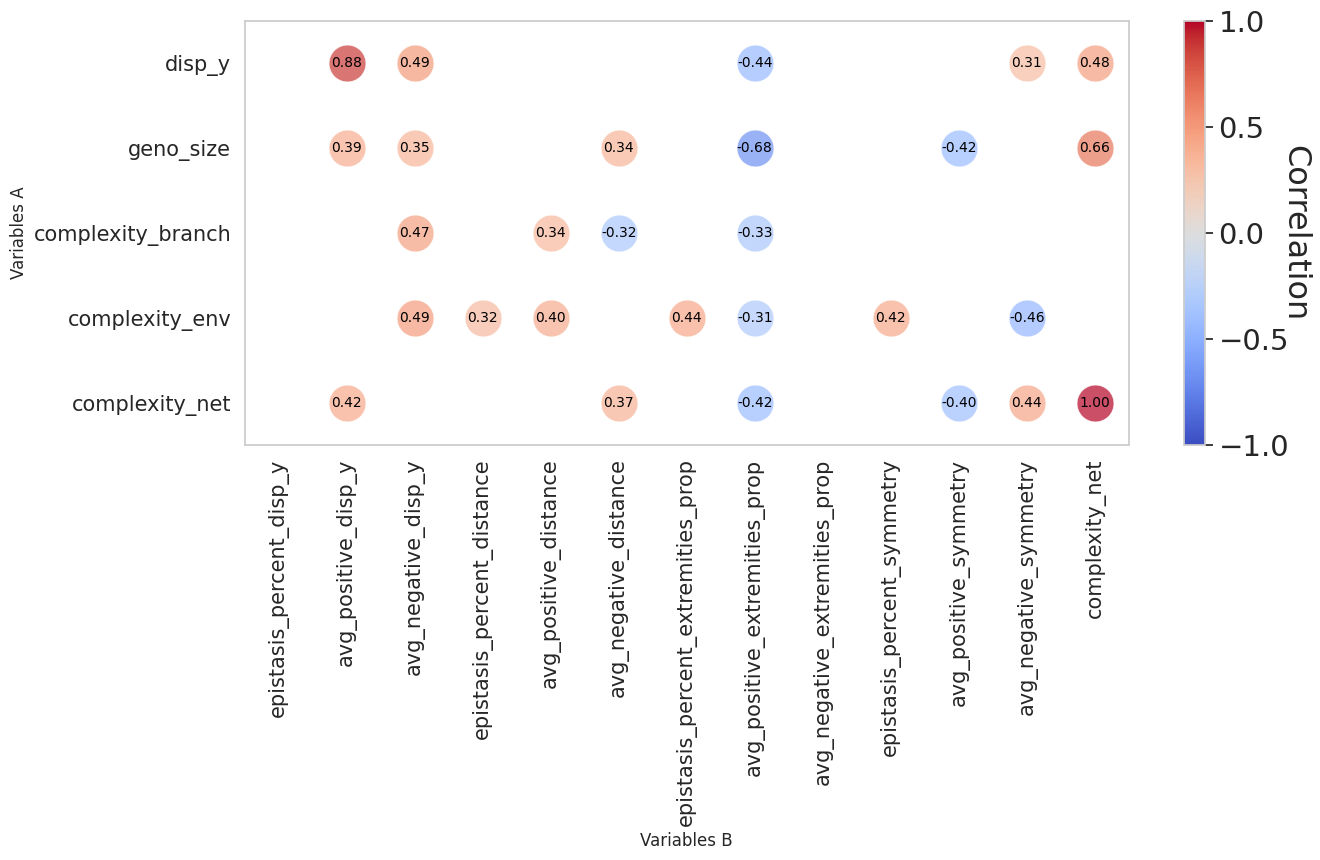

>> reg2m2


,epistasis_percent_disp_y,avg_positive_disp_y,avg_negative_disp_y,epistasis_percent_distance,avg_positive_distance,avg_negative_distance,epistasis_percent_extremities_prop,avg_positive_extremities_prop,avg_negative_extremities_prop,epistasis_percent_symmetry,avg_positive_symmetry,avg_negative_symmetry,complexity_net
disp_y,-0.370184,0.546717,0.583398,-0.364774,0.646349,0.133058,-0.303512,0.308062,-0.015346,-0.337477,0.194695,0.014850,-0.191721
geno_size,-0.150105,0.154590,-0.392668,-0.166050,-0.324470,-0.440498,-0.306380,-0.268773,-0.302845,-0.113165,-0.194903,-0.296943,0.833966
complexity_branch,0.040760,0.327164,-0.150074,0.049028,-0.067525,-0.073359,0.024170,-0.061120,-0.291861,0.040845,0.380958,-0.090898,0.129488
complexity_env,0.386361,0.272651,-0.168061,0.377196,-0.133093,-0.339606,0.198732,-0.245739,-0.413876,0.378976,0.042476,-0.602257,0.260221
complexity_net,-0.225788,0.183220,-0.461557,-0.241001,-0.259093,-0.394292,-0.332950,0.067314,-0.094362,-0.178573,-0.009870,-0.081550,1.000000


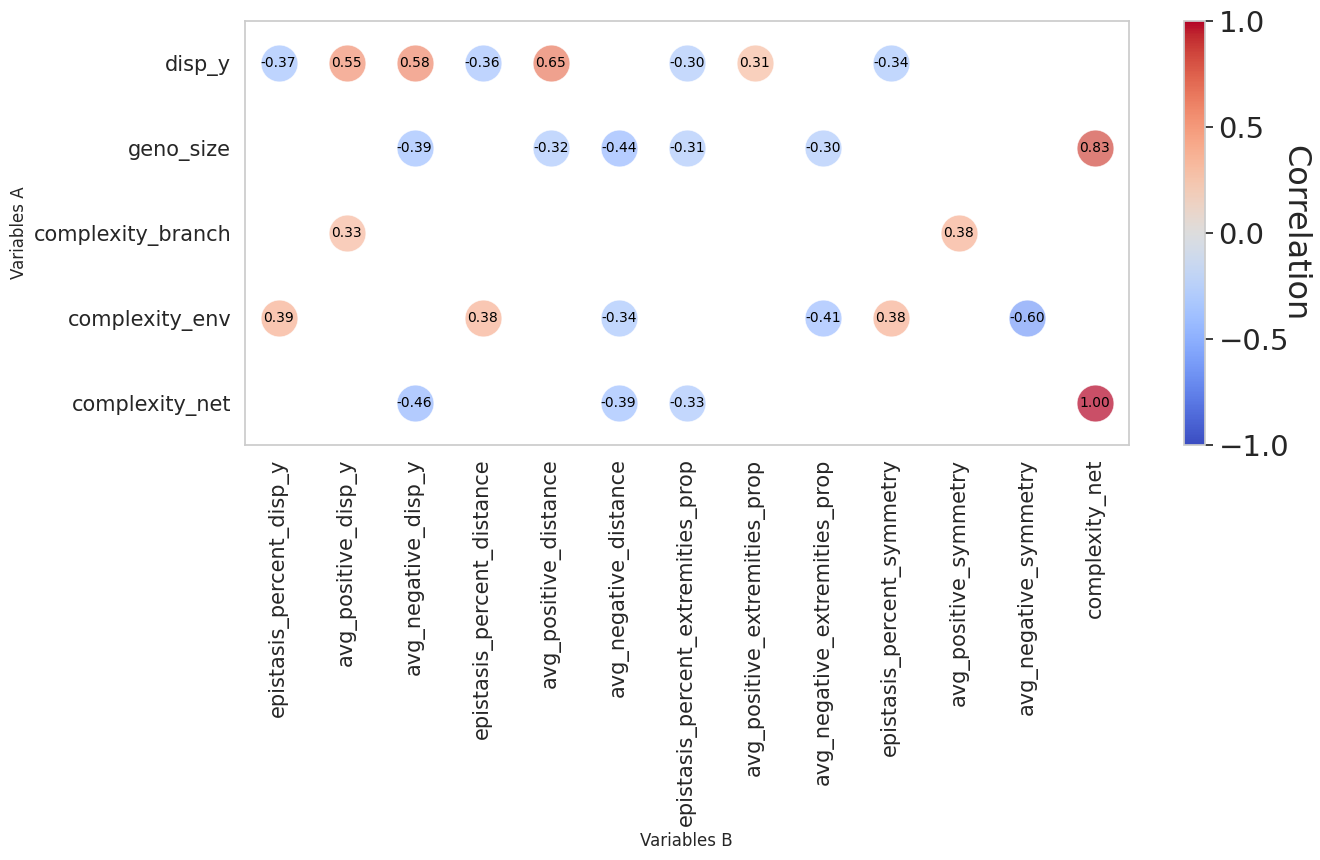

In [241]:
### CORRELATIONS: EPISTASIS VS PHENOCOMPLEXITY

keys = ['experiment_name', 'run', 'gen', 'individual_id']

df_complexity_net = pd.read_csv(f'{path}/complexity/complexity_net.csv').drop(columns=['ranking'])
df_complexity_all = pd.merge(df_complexity, df_complexity_net, on=keys, how='inner')

df_complexity_end = df_complexity_all[(df_complexity_all['gen'] == 100)]

metrics1 = ['disp_y','geno_size', 'complexity_branch', 'complexity_env', 'complexity_net']
#metrics1 = ['disp_y', 'complexity_branch', 'complexity_env', 'complexity_net']

metrics2 = []

for idx,trait in enumerate(traits):
    df_trait = df_traits[trait].copy(deep=True) 
    df_trait = df_trait.drop(columns=['Unnamed: 0'])

    corr_df = pd.merge(df_complexity_end, df_trait, on=keys, how='inner')
    corr_df = corr_df.rename(columns={'epistasis_percent': 'epistasis_percent_'+trait, 
                                      'avg_positive': 'avg_positive_'+trait, 
                                      'avg_negative': 'avg_negative_'+trait})
    metrics2.append('epistasis_percent_'+trait)
    metrics2.append('avg_positive_'+trait)
    metrics2.append('avg_negative_'+trait)
   
    corr_df['complexity_net'] = corr_df['complexity_net']/ corr_df['geno_size']

    obsolete_vars = ['symmetry', 'extremities_prop' ,'neutral', 'positive', 'negative', 'epistasis']
    redudant_vars = [ 'ranking', 'disp_y', 'geno_size','complexity_env','complexity_branch', 'complexity_net']

    if idx == 0:
        corr_df_all = corr_df.drop(columns=obsolete_vars)
    else:
        corr_df = corr_df.drop(columns=obsolete_vars+redudant_vars)
        corr_df_all = pd.merge(corr_df_all, corr_df, on=keys, how='inner')

    
for idx_experiment, exp in enumerate(experiments):
    print('>>', exp)
    df_complexity_end_exp = corr_df_all[(corr_df_all['experiment_name'] == exp)]
    df_complexity_end_exp = df_complexity_end_exp[ (df_complexity_end_exp['ranking'] == 'best') ] 
    #display(df_complexity_end_exp)

    corr_matrix = df_complexity_end_exp[metrics1+metrics2].corr()
    #corr_matrix = corr_matrix.loc[metrics1, metrics2+['complexity_net', 'geno_size', 'disp_y'] ] 
    corr_matrix = corr_matrix.loc[metrics1, metrics2+['complexity_net'] ] 
    display(corr_matrix)

    ##################################
    # Filter out correlations below the threshold
    threshold = 0.3
    filtered_corr_matrix = corr_matrix.copy()
    filtered_corr_matrix[abs(filtered_corr_matrix) < threshold] = np.nan
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 9))
    
    # Define color map and normalization
    cmap = plt.get_cmap('coolwarm')
    norm = plt.Normalize(vmin=-1, vmax=1)
   
    # Plot each circle based on the filtered correlation matrix
    for i, var_a in enumerate(filtered_corr_matrix.index):
        for j, var_b in enumerate(filtered_corr_matrix.columns):
            corr_value = filtered_corr_matrix.loc[var_a, var_b]
            if not np.isnan(corr_value):
                size = abs(corr_value) * 3000  # Scale size of the circle
                color = cmap(norm(corr_value))  # Map correlation to color (blue to red)
                
                # Plot a circle at the grid position
                ax.scatter(j, i, color=color, alpha=0.7, edgecolors='w', linewidth=0.5, s=700) #, s=size )
                ax.text(j, i, f'{corr_value:.2f}', color='black', fontsize=10, ha='center', va='center')
    
    # Set labels and title
    ax.set_xticks(range(len(filtered_corr_matrix.columns)))
    ax.set_yticks(range(len(filtered_corr_matrix.index)))
    ax.set_xticklabels(filtered_corr_matrix.columns, rotation=90, fontsize=15)  # Smaller font size
    ax.set_yticklabels(filtered_corr_matrix.index, fontsize=15)  # Smaller font size
    ax.set_xlabel('Variables B', size=12)
    ax.set_ylabel('Variables A', size=12)
    ax.set_title('', size=16)
    
    # Adjust the spacing between plot elements
    ax.set_xlim(-0.5, len(filtered_corr_matrix.columns) - 0.5)  # Ensure circles don't go out of bounds horizontally
    ax.set_ylim(len(filtered_corr_matrix.index) - 0.5, -0.5)   # Ensure circles don't go out of bounds vertically
    
    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
    cbar = plt.colorbar(sm)
    cbar.set_label('Correlation', rotation=270, labelpad=15)
    
    # Add size legend
    #sizes = [100, 500, 1000]  # Sizes for the legend
    #size_labels = [f'{size/1000:.1f}' for size in sizes]
    #patches = [mpatches.Circle((0, 0), radius=np.sqrt(size/1000), color='grey', alpha=0.7) for size in sizes]
    #ax.legend(patches, size_labels, title="Correlation Strength", title_fontsize='13', loc='upper right', fontsize='10', frameon=False)
    
    # Show the plot
    plt.grid(False)
    plt.tight_layout()
    plt.show()




 >>>>> complexity_env

 >>> reg10m2
Average of 'b' in the first : 14.266666666666667
Average of 'b' in the second : 16.0
  p-value: 0.4842


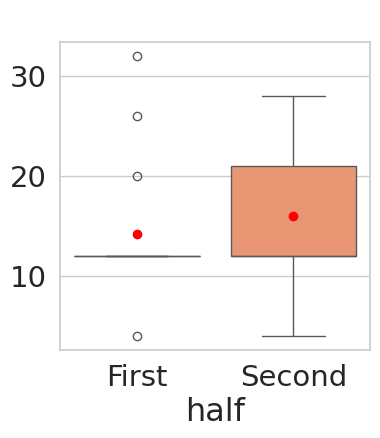


 >>> reg2m2
Average of 'b' in the first : 14.933333333333334
Average of 'b' in the second : 17.733333333333334
  p-value: 0.1475


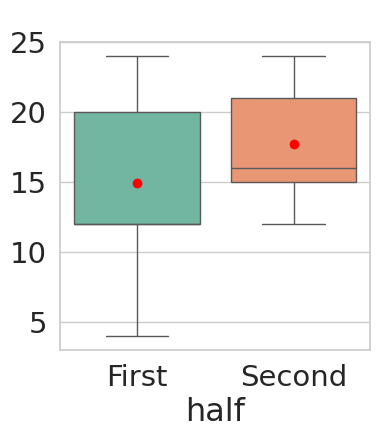


 >>>>> complexity_net

 >>> reg10m2
Average of 'b' in the first : 1.20541849685766
Average of 'b' in the second : 1.4833171495171498
  p-value: 0.2035


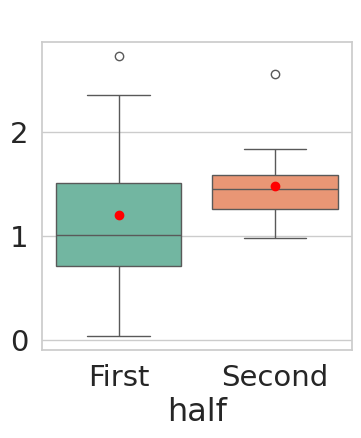


 >>> reg2m2
Average of 'b' in the first : 2.0535435755075184
Average of 'b' in the second : 4.068602518212177
  p-value: 0.0


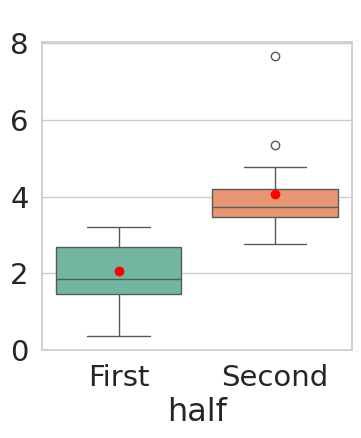


 >>>>> disp_y

 >>> reg10m2
Average of 'b' in the first : 1.3665596705358147
Average of 'b' in the second : 1.7548485339774438
  p-value: 0.0862


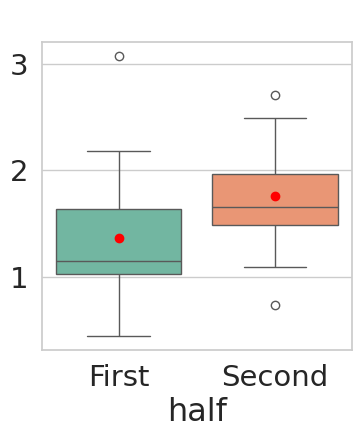


 >>> reg2m2
Average of 'b' in the first : 2.1201436329943424
Average of 'b' in the second : 2.162267770400892
  p-value: 0.8098


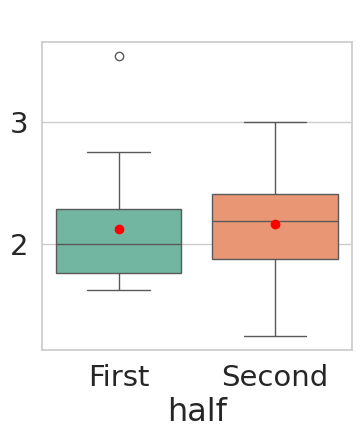

In [242]:

### COMPLEXITY VS SIZE 


# metrics_dist = ['geno_size', 'complexity_net', 'disp_y']
# metric_order = 'complexity_env'
metrics_dist = ['complexity_env', 'complexity_net', 'disp_y']
metric_order = 'geno_size'

for metric_dist in metrics_dist:
    print('\n >>>>>',metric_dist)
    for exp in experiments:
        print('\n >>>',exp)
        df_comp_g = corr_df_all[ (corr_df_all['experiment_name'] == exp) ] 
        df_comp_g = df_comp_g[ (df_comp_g['ranking'] == 'best') ] 
        df_sorted = df_comp_g.sort_values(by=metric_order).reset_index(drop=True)
               
        # first_half = df_comp_g[ (df_comp_g[metric_order] <20) ] 
        # second_half = df_comp_g[ (df_comp_g[metric_order] >= 20) ] 

        midpoint = len(df_sorted) // 2
        first_half = df_sorted.iloc[:midpoint]
        second_half = df_sorted.iloc[midpoint:]
        
        # Calculate and display the averages for 'b' in each half
        avg_first_half = first_half[metric_dist].mean()
        avg_second_half = second_half[metric_dist].mean()
     #   display(first_half)
      #  display(second_half)
        print(f"Average of 'b' in the first : {avg_first_half}")
        print(f"Average of 'b' in the second : {avg_second_half}")
        
        t_stat, p_value = ttest_ind(first_half[metric_dist], second_half[metric_dist], equal_var=True)
       # _, p_value = wilcoxon(first_half[metric_dist], second_half[metric_dist])
        #_, p_value = mannwhitneyu(first_half[metric_dist], second_half[metric_dist], alternative='two-sided')
        print(f"  p-value: {round(p_value, 4)}")
        
        # Add a new column to each half to indicate "First Half" or "Second Half"
        first_half['half'] = 'First'
        second_half['half'] = 'Second'
        
        #  Concatenate the two halves back into a single DataFrame
        df_concat = pd.concat([first_half, second_half], ignore_index=True)
        
        # Plot variable 'disp_y' for each half using box plots
        plt.figure(figsize=(4, 4))
        sb.boxplot(x='half', y=metric_dist, data=df_concat, palette="Set2")
        
        plt.scatter(x=[0], y=[avg_first_half], color='red', label='Mean', zorder=5)
        plt.scatter(x=[1], y=[avg_second_half], color='red', zorder=5)
        
        plt.title(' ')
        plt.ylabel('' )
        plt.show() 
